#DSCI 417 – Project 03
##Forest Cover Prediction
**Chris Moore**

##Part A: Set up Environment

In [0]:
from pyspark.ml.feature import VectorAssembler, StringIndexer,OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
from pyspark.sql.functions import expr
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np




spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

##Part B: Load and Explore the Data

In [0]:
 

fc_schema = (
    'Elevation Integer, Aspect Integer,Slope Integer,Horizontal_Distance_To_Hydrology Integer,'
    'Vertical_Distance_To_Hydrology Integer,Horizontal_Distance_To_Roadways Integer,Hillshade_9am Integer,'
    'Hillshade_Noon Integer,Hillshade_3pm Integer,Horizontal_Distance_To_Fire_Points Integer,'
    'Wilderness_Area String,Soil_Type Integer,Cover_Type Integer'
)
 
fc = (
    spark.read
    .option('delimiter', '\t')
    .option('header', True)
    .schema(fc_schema)
    .csv('/FileStore/tables/forest_cover.txt')
)

fc.printSchema()

root
-- Elevation: integer (nullable = true)
-- Aspect: integer (nullable = true)
-- Slope: integer (nullable = true)
-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
-- Vertical_Distance_To_Hydrology: integer (nullable = true)
-- Horizontal_Distance_To_Roadways: integer (nullable = true)
-- Hillshade_9am: integer (nullable = true)
-- Hillshade_Noon: integer (nullable = true)
-- Hillshade_3pm: integer (nullable = true)
-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
-- Wilderness_Area: string (nullable = true)
-- Soil_Type: integer (nullable = true)
-- Cover_Type: integer (nullable = true)

In [0]:
fc_cols=fc.columns

fc.select(fc_cols[:6]).show(3)
fc.select(fc_cols[6:]).show(3)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|
+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
 2596| 51| 3| 258| 0| 510|
 2590| 56| 2| 212| -6| 390|
 2804| 139| 9| 268| 65| 3180|
+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
only showing top 3 rows

+-------------+--------------+-------------+----------------------------------+---------------+---------+----------+
Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area|Soil_Type|Cover_Type|
+-------------+--------------+-------------+----------------------------------+---------------+---------+----------+
 221| 232| 148| 6279| Rawah| 29| 5|
 220| 235| 151| 6225| Rawah| 29| 5|
 234| 238| 135| 6121| Rawah| 12| 2|
+-------------+--------------+-------------+----------------------------------+---------------+---------+----------+
only showing top 3 rows

In [0]:
N=fc.count()
print('There are a total of',N,'Records in the fc dataframe')

There are a total of 15120 Records in the fc dataframe

In [0]:
( 
fc
.groupBy('Cover_Type')
.agg(
    expr('COUNT(*) AS n_covers')
)
.withColumn('prop', expr(f'ROUND((n_covers/{N}), 4)'))
.select('Cover_Type','prop')
.show()
)

#It's seems odd that we have the same proportion of each cover type. 

+----------+------+
Cover_Type| prop|
+----------+------+
 1|0.1429|
 6|0.1429|
 3|0.1429|
 5|0.1429|
 4|0.1429|
 7|0.1429|
 2|0.1429|
+----------+------+

##Part C: Preprocessing and Splitting the Data

In [0]:
num_features=(fc_cols[:-3])
cat_features=(fc_cols[-3:-1])

ix_features = [c + '_ix' for c in cat_features]
vec_features = [c + '_vec' for c in cat_features]

#label_indexer = StringIndexer(inputCol='Cover_Type', outputCol='label')
indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)
encoder = OneHotEncoder(inputCols=ix_features, outputCols=vec_features,dropLast=False)
assembler_lr = VectorAssembler(inputCols=num_features + vec_features, outputCol='features_lr')
assembler_dt = VectorAssembler(inputCols=num_features + ix_features, outputCol='features_dt')

In [0]:
format_data = Pipeline(stages=[indexer, encoder,assembler_lr,assembler_dt]).fit(fc)
fc_proc = format_data.transform(fc)

fc_proc.persist()
fc_proc.select(['features_dt', 'Cover_Type']).show(5, truncate=False)


+-----------------------------------------------------------------------+----------+
features_dt |Cover_Type|
+-----------------------------------------------------------------------+----------+
[2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,2.0,1.0] |5 |
[2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,2.0,1.0] |5 |
[2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,2.0,20.0] |2 |
[2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,2.0,6.0]|2 |
[2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,2.0,1.0] |5 |
+-----------------------------------------------------------------------+----------+
only showing top 5 rows

In [0]:
splits = fc_proc.randomSplit([0.8, 0.2], seed=1) 
train = splits[0] 
test = splits[1]

train.persist()

print(f'Training Observations: {train.count()}\n'
      f'Testing Observations:  {test.count()}' )

Training Observations: 12118
Testing Observations: 3002

##Part D: Hyperparameter for Logistic Regression

In [0]:
accuracy_eval = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Cover_Type', metricName='accuracy')

In [0]:
logreg = LogisticRegression(featuresCol='features_lr', labelCol='Cover_Type')
logreg_model = logreg.fit(train)

param_grid = (ParamGridBuilder()
              .addGrid(logreg.regParam, [0.00001, 0.0001, 0.001, 0.01, 0.1])
              .addGrid(logreg.elasticNetParam, [0, 0.5, 1])
             ).build()

cv = CrossValidator(estimator=logreg, estimatorParamMaps=param_grid, 
                    evaluator=accuracy_eval, numFolds=5, seed=1)

cv_model = cv.fit(train)

In [0]:
lr_model = cv_model.bestModel
lr_opt_score = max(cv_model.avgMetrics)
lr_opt_regParam = lr_model.getRegParam()
lr_opt_enetParam = lr_model.getElasticNetParam()

print(f'Max CV Score:   {round(lr_opt_score,4)}\n'
      f'Optimal Lambda: {round(lr_opt_regParam,4)}\n' 
      f'Optimal Alpha:  {round(lr_opt_regParam,4)}')

Max CV Score: 0.705
Optimal Lambda: 0.0
Optimal Alpha: 0.0

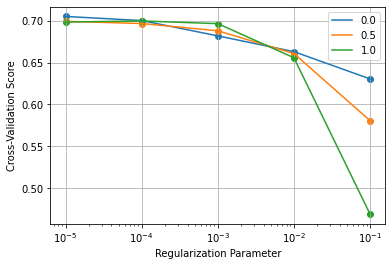

In [0]:
model_params = cv_model.getEstimatorParamMaps() 
 
lr_cv_summary_list = [] 
for param_set, acc in zip(model_params, cv_model.avgMetrics): 
    new_set = list(param_set.values()) + [acc] 
    lr_cv_summary_list.append(new_set) 
 
cv_summary = pd.DataFrame(lr_cv_summary_list,  
                          columns=['reg_param', 'enet_param', 'acc']) 
 
for en in cv_summary.enet_param.unique(): 
    sel = cv_summary.enet_param == en 
    plt.plot(cv_summary.reg_param[sel], cv_summary.acc[sel], label=en) 
    plt.scatter(cv_summary.reg_param[sel], cv_summary.acc[sel])   
 
plt.legend() 
plt.xscale('log') 
plt.grid() 
plt.xlabel('Regularization Parameter') 
plt.ylabel('Cross-Validation Score') 
plt.show() 

##Part E: Hyperparameter Tuning for Decision Trees

In [0]:
dtree = DecisionTreeClassifier(featuresCol='features_dt', labelCol='Cover_Type', maxBins=38,seed=1)

param_grid = (ParamGridBuilder()
              .addGrid(dtree.maxDepth, [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24])
              .addGrid(dtree.minInstancesPerNode, [1,2,4])
             ).build()

cv = CrossValidator(estimator=dtree, estimatorParamMaps=param_grid, 
                    evaluator=accuracy_eval, numFolds=5, seed=1)

cv_model = cv.fit(train)

In [0]:
dt_model = cv_model.bestModel

dt_opt_maxDepth = dt_model.getMaxDepth()
dt_opt_minInstancesPerNode = dt_model.getMinInstancesPerNode()
 
print('Max CV Score:   ', round(max(cv_model.avgMetrics),4))
print('Optimal Depth:  ', dt_opt_maxDepth)
print('Optimal MinInst:', dt_opt_minInstancesPerNode)

Max CV Score: 0.7775
Optimal Depth: 16
Optimal MinInst: 1

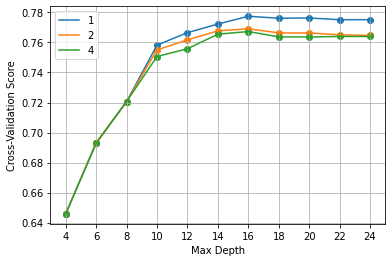

In [0]:
model_params = cv_model.getEstimatorParamMaps() 
 
dt_cv_summary_list = [] 
for param_set, acc in zip(model_params, cv_model.avgMetrics): 
    new_set = list(param_set.values()) + [acc] 
    dt_cv_summary_list.append(new_set) 
 
cv_summary = pd.DataFrame(dt_cv_summary_list,  
                          columns=['maxDepth', 'minInst', 'acc']) 
 
for mi in cv_summary.minInst.unique(): 
    sel = cv_summary.minInst == mi 
    plt.plot(cv_summary.maxDepth[sel], cv_summary.acc[sel], label=mi) 
    plt.scatter(cv_summary.maxDepth[sel], cv_summary.acc[sel])   
     
plt.legend() 
plt.grid() 
plt.xticks(range(4,26,2)) 
plt.xlabel('Max Depth') 
plt.ylabel('Cross-Validation Score') 
plt.show() 

In [0]:
features = num_features + cat_features
pd.DataFrame({
    'feature':features,
    'importance':dt_model.featureImportances
})

Out[16]:

,feature,importance
0,Elevation,0.394260
1,Aspect,0.048116
2,Slope,0.026453
3,Horizontal_Distance_To_Hydrology,0.078278
4,Vertical_Distance_To_Hydrology,0.036748
5,Horizontal_Distance_To_Roadways,0.070875
6,Hillshade_9am,0.025840
7,Hillshade_Noon,0.023199
8,Hillshade_3pm,0.017314
9,Horizontal_Distance_To_Fire_Points,0.079365


##Part F: Identifying and Evaluating the Final Model

The decision tree model has a cross validation score of 0.7775 compared to the logreg model which has a CV score of 0.705. Based on the CV scores the DT model should produce a higher accuracy predication of Cover_Type. Although not nearly as important as accuracy the DT model took 5.31 minutes to complete and the LR model took 7.32 seconds to complete. This is not surprising as a DT model will typically perform better than a LR model for most data sets.

In [0]:
test_pred = dt_model.transform(test)
test_pred.select(['probability', 'prediction', 'Cover_Type']).show(10, truncate=False)

+------------------------------------------------------------------------------+----------+----------+
probability |prediction|Cover_Type|
+------------------------------------------------------------------------------+----------+----------+
[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0] |6.0 |6 |
[0.0,0.0,0.0273972602739726,0.3150684931506849,0.0,0.0,0.6575342465753424,0.0]|6.0 |6 |
[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0] |6.0 |6 |
[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0] |3.0 |3 |
[0.0,0.0,0.0,0.09375,0.0,0.0,0.90625,0.0] |6.0 |6 |
[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0] |3.0 |3 |
[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0] |3.0 |6 |
[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0] |3.0 |3 |
[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0] |6.0 |3 |
[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0] |6.0 |6 |
+------------------------------------------------------------------------------+----------+----------+
only showing top 10 rows

In [0]:
pred_and_labels = test_pred.rdd.map(lambda x:(x['prediction'],float(x['Cover_Type'])))
metrics = MulticlassMetrics(pred_and_labels)

print (f'Test Set Accuracy: {round(metrics.accuracy,4)}')

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(
Test Set Accuracy: 0.7818

In [0]:
labels1 =['1','2','3','4','5','6','7']

cm = metrics.confusionMatrix().toArray().astype(int)
 
pd.DataFrame(
    data=cm, 
    columns=labels,
    index=labels
)

Out[31]:

,1,2,3,4,5,6,7
1,311,90,2,0,13,5,36
2,101,220,12,0,58,11,3
3,1,10,306,23,13,78,0
4,0,1,22,423,0,25,0
5,9,26,3,0,364,4,0
6,1,4,58,13,5,319,0
7,19,7,0,0,2,0,404


Observations in the test set with Cover Type 02 were misclassified by the model as Cover Type 01 a total 
of 101 times. This was the most common type of misclassification in the test set.

In [0]:
print('Label       Precision   Recall')
print('------------------------------')
#for i, lab in enumerate(labels1):
    #print(f'{lab:<12}{metrics.precision(i):<12.4f}{metrics.recall(i):.4f}')
    
print(f'{"01":<12}{metrics.precision(1):<12.4f}{metrics.recall(1):.4f}\n'
      f'{"02":<12}{metrics.precision(2):<12.4f}{metrics.recall(2):.4f}\n'
      f'{"03":<12}{metrics.precision(3):<12.4f}{metrics.recall(3):.4f}\n'
      f'{"04":<12}{metrics.precision(4):<12.4f}{metrics.recall(4):.4f}\n'
      f'{"05":<12}{metrics.precision(5):<12.4f}{metrics.recall(5):.4f}\n'
      f'{"06":<12}{metrics.precision(6):<12.4f}{metrics.recall(6):.4f}\n'
      f'{"07":<12}{metrics.precision(7):<12.4f}{metrics.recall(7):.4f}\n')
    

# The for loop above kept giving me a key error that I couldn't figure out so I just hand jammed each line. I realize this would be feasible with more labels.  

Label Precision Recall
------------------------------
01 0.7036 0.6805
02 0.6145 0.5432
03 0.7593 0.7100
04 0.9216 0.8981
05 0.8000 0.8966
06 0.7217 0.7975
07 0.9120 0.9352

1. Which cover type is most likely to be correctly classified by our final model?  Cover type 07 was correctly identified 93% of the time. The closest second was Cover type 05 at 90%

2. Which cover type is most likely to be misclassified by our final model?   Cover type 02 had a 61% precision and 54% recall. 

3. Which cover type has the greatest difference between its precision and recall? Explain the meaning of 
both of these values with respect to this cover type. Cover type 05 had a precision of 80% and a recall of 89%. Precision is sum of true positives divided by the sum of true positives and false positives. Recall is the sum of true positives divided by the sum of true positives and false negatives.